In [111]:
import sys 
sys.path.append("../build/src/Interpolation_Module")

In [112]:
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np
import interpolation_bindings as ib 

In [113]:
import numpy as np
import pandas as pd

def sample_values(values, num_samples):
    values = np.array(values)  # Ensure values is a NumPy array
    x = np.random.choice(values, num_samples-2, replace=False)
    x = list(x)  # Convert NumPy array to list
    # Ensure the first and last elements of values are included
    if values[0] not in x:
        x.append(values[0])
    if values[-1] not in x:
        x.append(values[-1])
    x.sort()
    y = [np.sin(x_i) for x_i in x]
    data = pd.DataFrame({'x': x, 'y': y})
    return data

def data_generator(min, max, num_points, function):
    x = np.linspace(min, max, num_points)
    y = function(x)
    return pd.DataFrame({'x': x, 'y': y})
def random_data_generator(min, max, num_points, seed=None):
    x = np.linspace(min, max, num_points)
    y = np.random.rand(num_points)
    return pd.DataFrame({'x': x, 'y': y})

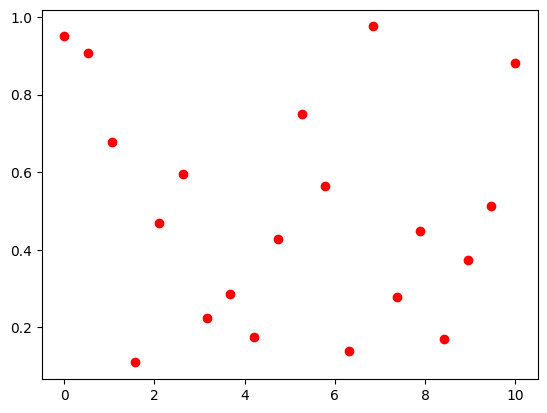

In [114]:
# Generating some random data and interpolating it
random_data = random_data_generator(0, 10, 20, seed = 17)
random_points = ib.df_to_set_of_points(random_data)
plt.plot(random_data['x'], random_data['y'], 'ro', label='Data points')
plt.show()

Plotting interpolations for 1000 random points in the interval [0, 10]...


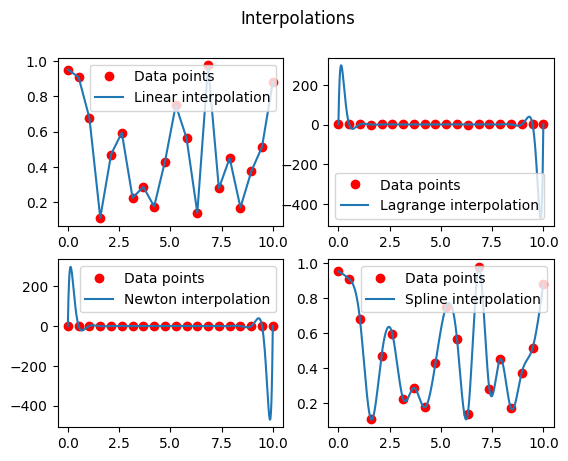

In [115]:

# Interpolating the data
linear_interpolation = ib.LinearInterpolation(random_points)
lagrange_interpolation = ib.Lagrange(random_points)
newton_interpolation = ib.Newton(random_points)
spline_interpolation = ib.SplineInterpolation(random_points)


x = np.linspace(0, 10, 1000)
y_linear = [linear_interpolation.interpolate(x_i) for x_i in x]
y_lagrange = [lagrange_interpolation.interpolate(x_i) for x_i in x]
y_newton = [newton_interpolation.interpolate(x_i) for x_i in x]
y_spline = [spline_interpolation.interpolate(x_i) for x_i in x]

print("Plotting interpolations for 1000 random points in the interval [0, 10]...")

# Showing the four graphs in one divided in 2x2
fig, axs = plt.subplots(2, 2)
fig.suptitle('Interpolations')
axs[0, 0].plot(random_data['x'], random_data['y'], 'ro', label='Data points')
axs[0, 0].plot(x, y_linear, label='Linear interpolation')
axs[0, 0].legend()

axs[0, 1].plot(random_data['x'], random_data['y'], 'ro', label='Data points')
axs[0, 1].plot(x, y_lagrange, label='Lagrange interpolation')
axs[0, 1].legend()

axs[1, 0].plot(random_data['x'], random_data['y'], 'ro', label='Data points')
axs[1, 0].plot(x, y_newton, label='Newton interpolation')
axs[1, 0].legend()

axs[1, 1].plot(random_data['x'], random_data['y'], 'ro', label='Data points')
axs[1, 1].plot(x, y_spline, label='Spline interpolation')
axs[1, 1].legend()

plt.show()


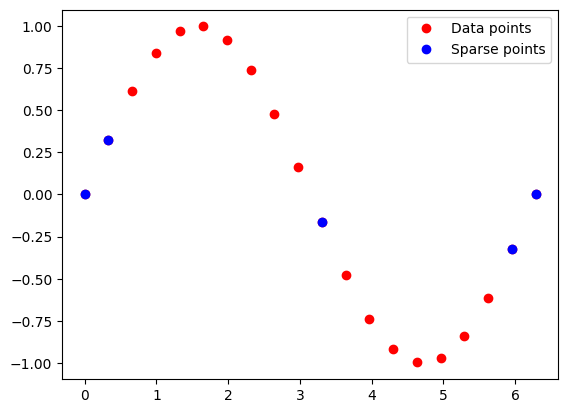

In [116]:
data = data_generator(0, 2*np.pi, 20, np.sin)

# Interpolating the data
points = ib.df_to_set_of_points(data)

sparse_data = sample_values(data['x'], 5)
sparse_points = ib.df_to_set_of_points(sparse_data)

# plotting the data
plt.plot(data['x'], data['y'], 'ro', label='Data points')
plt.plot(sparse_data['x'], sparse_data['y'], 'bo', label='Sparse points')
plt.legend()
plt.show()

In [117]:
x_values = np.linspace(min(sparse_data['x']), max(sparse_data['x']), 1000)

In [118]:
linear_interpolation = ib.LinearInterpolation(sparse_points)

In [119]:
y_linear = [linear_interpolation.interpolate(x_i) for x_i in x_values]

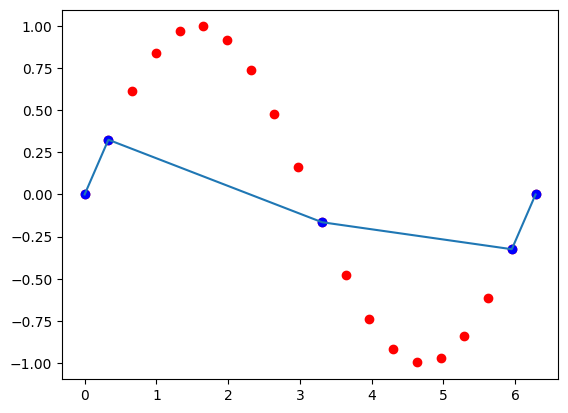

In [120]:
## plotting fitted values
plt.plot(data['x'], data['y'], 'ro', label='Data points')
plt.plot(sparse_data['x'], sparse_data['y'], 'bo', label='Sparse points')
plt.plot(x_values, y_linear, label='Linear interpolation')

In [121]:
spline = ib.SplineInterpolation(sparse_points)

In [122]:
y_spline = [spline.interpolate(x_i) for x_i in x_values]

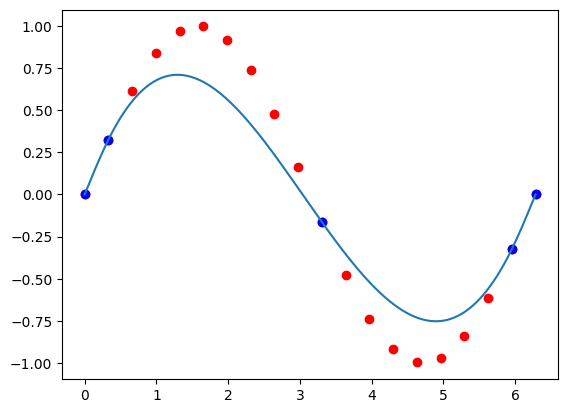

In [123]:
## plotting
plt.plot(data['x'], data['y'], 'ro', label='Data points')
plt.plot(sparse_data['x'], sparse_data['y'], 'bo', label='Sparse points')
plt.plot(x_values, y_spline, label='Spline interpolation')

In [124]:
sparse_x = np.linspace(min(sparse_data['x']), max(sparse_data['x']), 4)

In [125]:
sparse_x

array([0.        , 2.0943951 , 4.1887902 , 6.28318531])

In [126]:
sparse_y = [np.sin(x_i) for x_i in sparse_x]

In [127]:
sparse_data = pd.DataFrame({'x': sparse_x, 'y': sparse_y})

In [128]:
sparse_points = ib.df_to_set_of_points(sparse_data)

In [129]:
linear_interpolation = ib.LinearInterpolation(sparse_points)
y_linear = [linear_interpolation.interpolate(x_i) for x_i in x_values]

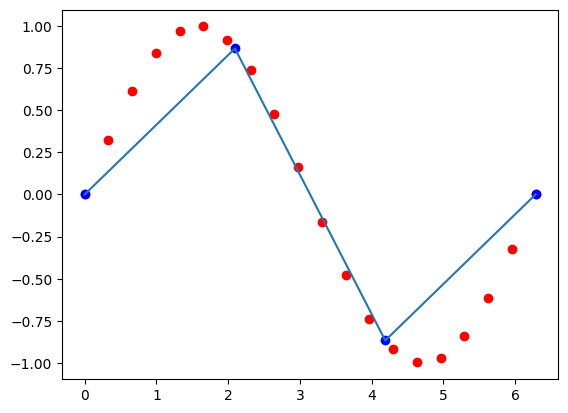

In [130]:
## plotting
plt.plot(data['x'], data['y'], 'ro', label='Data points')
plt.plot(sparse_data['x'], sparse_data['y'], 'bo', label='Sparse points')
plt.plot(x_values, y_linear, label='Linear interpolation')


In [131]:
def sparse_points_generator(min, max, n):
    sparse_x = np.linspace(min, max, n)
    sparse_y = [np.sin(x_i) for x_i in sparse_x]
    sparse_data = pd.DataFrame({'x': sparse_x, 'y': sparse_y})
    return ib.df_to_set_of_points(sparse_data)

In [132]:
n_points = [4, 8, 16, 32, 64]

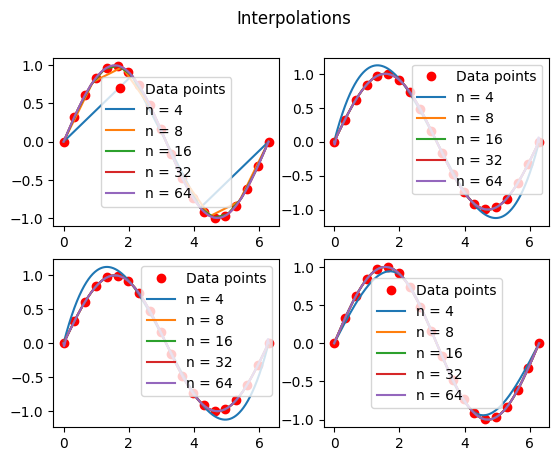

In [133]:
vec_sparse_points = []
linear_ooc = []
lagrangge_ooc = []
newton_ooc = []
spline_ooc = []

fig, axs = plt.subplots(2, 2)
fig.suptitle('Interpolations')
axs[0, 0].plot(data['x'], data['y'], 'ro', label='Data points')
axs[0, 1].plot(data['x'], data['y'], 'ro', label='Data points')
axs[1, 0].plot(data['x'], data['y'], 'ro', label='Data points')
axs[1, 1].plot(data['x'], data['y'], 'ro', label='Data points')

for i in range(len(n_points)):
    sparse_points = sparse_points_generator(0, 2*np.pi, n_points[i])
    vec_sparse_points.append(sparse_points)
    if i != 0:
        linear_ooc.append(ib.AnalysisInterpolation().OrderConvergenceAnalysis(points, vec_sparse_points[i-1], vec_sparse_points[i], "linear"))
        lagrangge_ooc.append(ib.AnalysisInterpolation().OrderConvergenceAnalysis(points, vec_sparse_points[i-1], vec_sparse_points[i], "lagrange"))
        newton_ooc.append(ib.AnalysisInterpolation().OrderConvergenceAnalysis(points, vec_sparse_points[i-1], vec_sparse_points[i], "newton"))
        spline_ooc.append(ib.AnalysisInterpolation().OrderConvergenceAnalysis(points, vec_sparse_points[i-1], vec_sparse_points[i], "cubic_spline"))
    linear_interpolation = ib.LinearInterpolation(sparse_points)
    lagrange_interpolation = ib.Lagrange(sparse_points)
    newton_interpolation = ib.Newton(sparse_points)
    spline_interpolation = ib.SplineInterpolation(sparse_points)
    y_linear = [linear_interpolation.interpolate(x_i) for x_i in x_values]
    y_lagrange = [lagrange_interpolation.interpolate(x_i) for x_i in x_values]
    y_newton = [newton_interpolation.interpolate(x_i) for x_i in x_values]
    y_spline = [spline_interpolation.interpolate(x_i) for x_i in x_values]
    axs[0, 0].plot(x_values, y_linear, label='n = ' + str(n_points[i]))
    axs[0, 1].plot(x_values, y_lagrange, label='n = ' + str(n_points[i]))
    axs[1, 0].plot(x_values, y_newton, label='n = ' + str(n_points[i]))
    axs[1, 1].plot(x_values, y_spline, label='n = ' + str(n_points[i]))
axs[0, 0].legend()
axs[0, 1].legend()
axs[1, 0].legend()
axs[1, 1].legend()
plt.show()
    

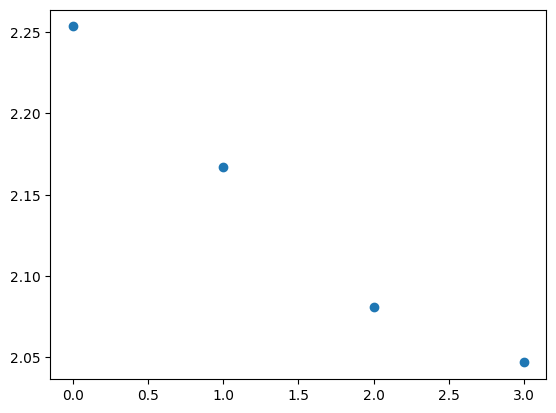

In [134]:
plt.plot(linear_ooc, 'o')